# ConvNet for image classification (CIFAR-10)

In [1]:
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tqdm import tqdm

%matplotlib inline

In [2]:
print(f'sys.version: {sys.version}')
print(f'tf.__version__: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
tf.__version__: 1.11.0


## Load CIFAR-10

In [3]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000, shuffle=False):
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Shuffle the data
    if shuffle:
        indices_train = np.arange(len(y_train))
        np.random.shuffle(indices_train)
        X_train = X_train[indices_train]
        y_train = y_train[indices_train]
        
        indices_test = np.arange(len(y_test))
        np.random.shuffle(indices_test)
        X_test = X_test[indices_test]
        y_test = y_test[indices_test]
    
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel
    
    stats = {}
    stats['mean_pixel'] = mean_pixel
    stats['std_pixel'] = std_pixel
    
    # Classes
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    return X_train, y_train, X_val, y_val, X_test, y_test, classes, stats

np.random.seed(67)
X_train, y_train, X_val, y_val, X_test, y_test, classes, stats = load_cifar10(num_training=49000, 
                                                                              num_validation=1000, 
                                                                              num_test=1000, 
                                                                              shuffle=True)
random_indices = np.random.choice(len(X_train), len(X_test), replace=False)
X_train_random = X_train[random_indices]
y_train_random = y_train[random_indices]
print('Classes: ', classes)
print('Train data shape: ', X_train.shape, '[', X_train.min(), X_train.max(), ']', X_train.dtype)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Train_random_subset data shape: ', X_train_random.shape)
print('Train_random_subset labels shape: ', y_train_random.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Classes:  ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train data shape:  (49000, 32, 32, 3) [ -1.9891398 2.1265779 ] float32
Train labels shape:  (49000,) int32
Train_random_subset data shape:  (1000, 32, 32, 3)
Train_random_subset labels shape:  (1000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Look at some images

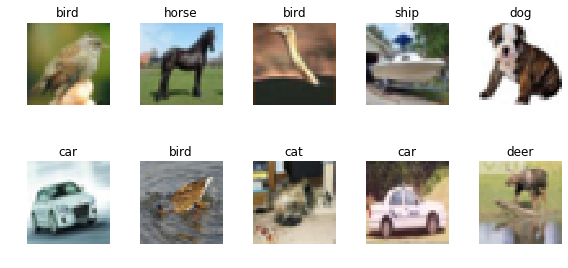

In [4]:
plt.figure(figsize=(8, 4))
batch = (X_train[0:10] * stats['std_pixel'] + stats['mean_pixel'])

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch[i].astype('int32'))
    plt.axis('off')
    plt.title(classes[y_train[i]])

plt.tight_layout()

## ConvNet

In [5]:
INIT_METHOD = 'glorot_normal'
EPOCHS = 16
BATCH_SIZE = 64
N = len(y_train)

start_indices = list(range(0, N, BATCH_SIZE))
end_indices = list(range(BATCH_SIZE, N, BATCH_SIZE))
if end_indices[-1] != N:
    end_indices.append(N)

In [6]:
# remove old logs and model_weights
#!rm -rf './logs'
#!rm -rf './model_weights'

In [7]:
#!mkdir './model_weights'

In [8]:
def write_weights(w, filename=f'./model_weights/tensorflow_weights_init_{INIT_METHOD}.txt'):
    with open(filename, 'w') as fo:
        json.dump(w, fo)

In [9]:
def conv_net(x):
    # weights
    init = None
    if INIT_METHOD == 'he_normal':
        init = tf.initializers.he_normal()
    elif INIT_METHOD == 'glorot_normal':
        init = tf.initializers.glorot_normal()
    
    with tf.variable_scope('conv1_weights'):
        w1 = tf.get_variable('w', shape=[5, 5, 3, 64], initializer=init)
        b1 = tf.get_variable('b', shape=[64], initializer=tf.initializers.zeros)
        tf.summary.image('weights', tf.transpose(w1, perm=[3, 0, 1, 2]),
                         max_outputs=64, collections=['weights_imgs'])
        tf.summary.histogram('weights', w1, collections=['weights_hists'])
        
    with tf.variable_scope('conv2_weights'):
        w2 = tf.get_variable('w', shape=[5, 5, 64, 16], initializer=init)
        b2 = tf.get_variable('b', shape=[16], initializer=tf.initializers.zeros)
        tf.summary.histogram('weights', w2, collections=['weights_hists'])
        
    with tf.variable_scope('fc3_weights'):
        w3 = tf.get_variable('w', shape=[400, 200], initializer=init)
        b3 = tf.get_variable('b', shape=[200], initializer=tf.initializers.zeros)
        tf.summary.histogram('weights', w3, collections=['weights_hists'])
        
    with tf.variable_scope('fc4_weights'):
        w4 = tf.get_variable('w', shape=[200, 10], initializer=init)
        b4 = tf.get_variable('b', shape=[10], initializer=tf.initializers.zeros)
        tf.summary.histogram('weights', w4, collections=['weights_hists'])
    
    # layers
    with tf.name_scope('conv1'):
        conv1 = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID', name='conv1') + b1
        relu1 = tf.nn.relu(conv1, name='relu1')
        max_pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='VALID', name='max_pool1')
    
    with tf.name_scope('conv2'):
        conv2 = tf.nn.conv2d(max_pool1, w2, strides=[1, 1, 1, 1], padding='VALID', name='conv2') + b2
        relu2 = tf.nn.relu(conv2, name='relu2')
        max_pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='VALID', name='max_pool1')
        max_pool2_reshaped = tf.reshape(max_pool2, [-1, 400])
    
    with tf.name_scope('fc3'):
        fc3 = tf.matmul(max_pool2_reshaped, w3) + b3
        relu3 = tf.nn.relu(fc3, name='relu3')
    
    with tf.name_scope('fc4_logits'):
        logits = tf.matmul(relu3, w4) + b4
    
    return logits

In [10]:
# reset default graph
tf.reset_default_graph()

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.int64)

with tf.name_scope('logits'):
    logits = conv_net(x)

with tf.name_scope('loss'):
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(x_entropy)
    loss_summary = tf.summary.scalar('loss', loss)

with tf.name_scope('optimization'):
    optimize = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

with tf.name_scope('accuracy'):
    y_pred = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

image_summaries = tf.summary.merge_all(key='weights_imgs')
histogram_summaries = tf.summary.merge_all(key='weights_hists')

# val_acc and val_loss for the last epoch
last_val_acc = None
last_val_loss = None

# let's train the conv_net
with tf.Session() as sess:
    # create summary writers
    logs_dir = './logs'
    train_summary_writer = tf.summary.FileWriter(logs_dir + f'/train/init_{INIT_METHOD}')
    val_summary_writer = tf.summary.FileWriter(logs_dir + f'/val/init_{INIT_METHOD}')
    test_summary_writer = tf.summary.FileWriter(logs_dir + f'/test/init_{INIT_METHOD}')
    
    # initialization
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(EPOCHS)):     
        # add summaries
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            train_loss_summary, train_acc_summary = sess.run([loss_summary, accuracy_summary],
                                                             feed_dict={
                                                                 x: X_train_random,
                                                                 y: y_train_random
                                                             })

            val_loss_summary, val_acc_summary = sess.run([loss_summary, accuracy_summary],
                                                         feed_dict={
                                                             x: X_val,
                                                             y: y_val
                                                         })
            
            test_loss_summary, test_acc_summary = sess.run([loss_summary, accuracy_summary],
                                                           feed_dict={
                                                               x: X_test,
                                                               y: y_test
                                                           })

            image_summary_res, histogram_summary_res = sess.run([image_summaries, 
                                                                 histogram_summaries])

            train_summary_writer.add_summary(train_loss_summary, epoch)
            train_summary_writer.add_summary(train_acc_summary, epoch)
            val_summary_writer.add_summary(val_loss_summary, epoch)
            val_summary_writer.add_summary(val_acc_summary, epoch)
            val_summary_writer.add_summary(image_summary_res, epoch)
            val_summary_writer.add_summary(histogram_summary_res, epoch)
            test_summary_writer.add_summary(test_loss_summary, epoch)
            test_summary_writer.add_summary(test_acc_summary, epoch)
            
            if epoch == EPOCHS - 1:
                # save last_val_loss and last_val_acc
                last_val_loss, last_val_acc = sess.run([loss, accuracy],
                                                       feed_dict={
                                                           x: X_val,
                                                           y: y_val
                                                       })
                
                # write weights of the model
                get_tensor = lambda tensor_name: sess.graph.get_tensor_by_name(tensor_name).eval().tolist()
                weights = {}
                weights['conv1_w'] = get_tensor('conv1_weights/w:0')
                weights['conv1_b'] = get_tensor('conv1_weights/b:0')
                weights['conv2_w'] = get_tensor('conv2_weights/w:0')
                weights['conv2_b'] = get_tensor('conv2_weights/b:0')
                weights['fc3_w'] = get_tensor('fc3_weights/w:0')
                weights['fc3_b'] = get_tensor('fc3_weights/b:0')
                weights['fc4_w'] = get_tensor('fc4_weights/w:0')
                weights['fc4_b'] = get_tensor('fc4_weights/b:0')
                write_weights(weights)
        
        # optimization
        for start_idx, end_idx in zip(start_indices, end_indices):
            sess.run(optimize,
                     feed_dict={
                         x: X_train[start_idx:end_idx],
                         y: y_train[start_idx:end_idx]
                     })
            
    # close summary writers
    train_summary_writer.close()
    val_summary_writer.close()
    test_summary_writer.close()

100%|██████████| 16/16 [01:44<00:00,  6.56s/it]


init_method: glorot_normal
val_acc: 63.70%
val_loss: 1.452


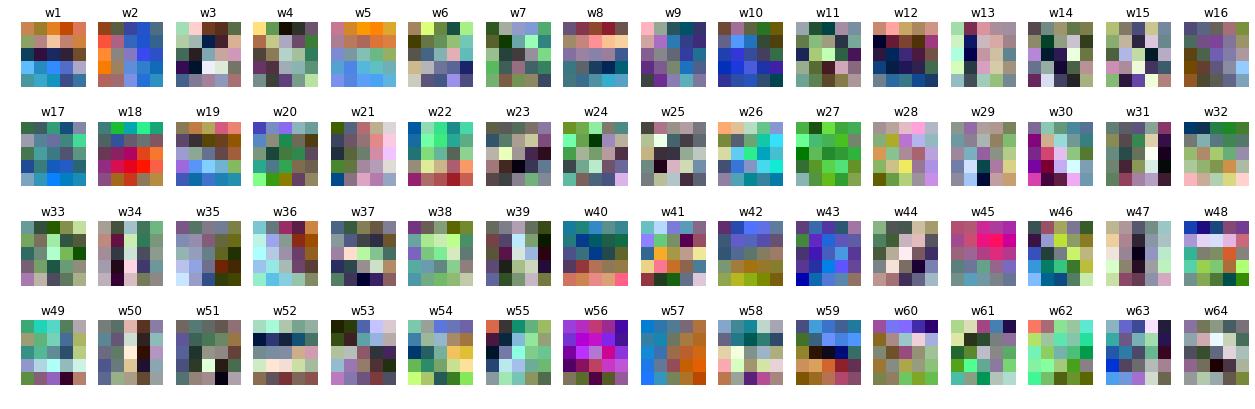

In [11]:
print(f'init_method: {INIT_METHOD}')
print(f'val_acc: {100*last_val_acc:.2f}%')
print(f'val_loss: {last_val_loss:.3f}')

def normalize_img(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

conv1_w = np.array(weights['conv1_w'])

plt.figure(figsize=(22, 7))
for i in range(conv1_w.shape[-1]):
    plt.subplot(4, conv1_w.shape[-1] // 4, i + 1)
    conv1_filter = normalize_img(conv1_w[:,:,:,i])
    plt.imshow(conv1_filter)
    plt.axis('off')
    plt.title(f'w{i+1}')

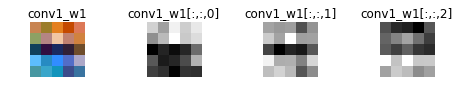

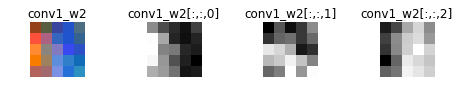

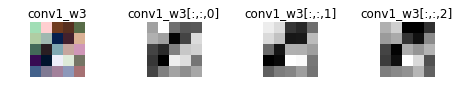

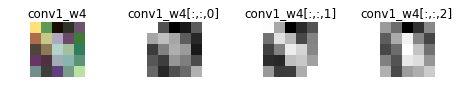

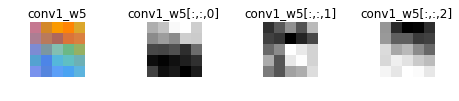

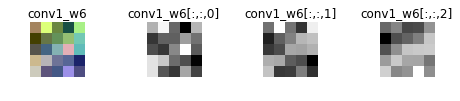

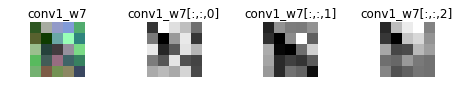

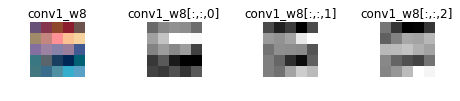

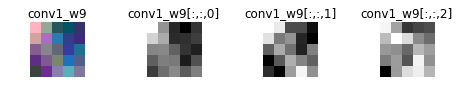

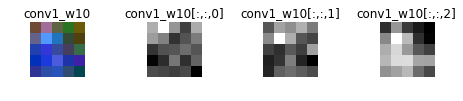

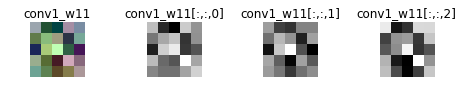

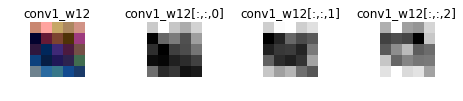

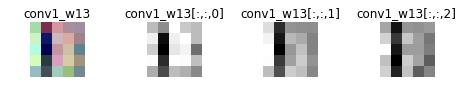

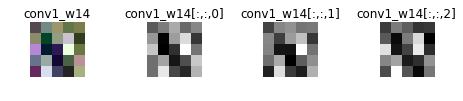

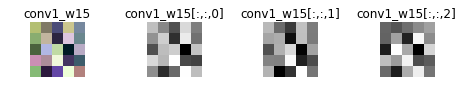

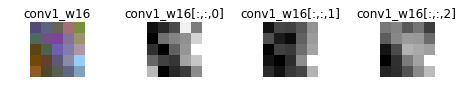

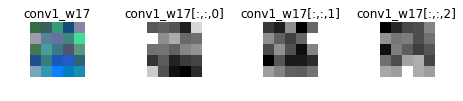

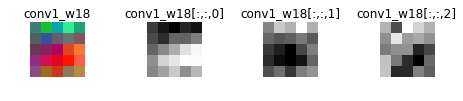

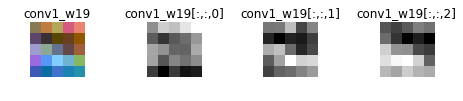

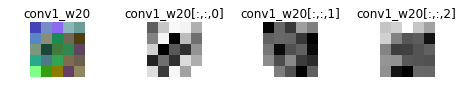

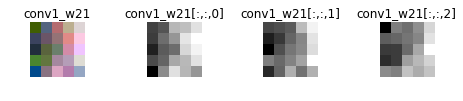

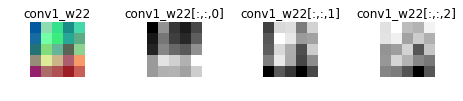

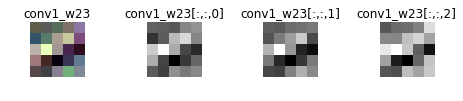

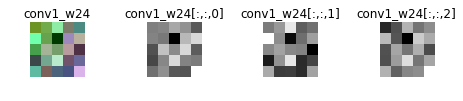

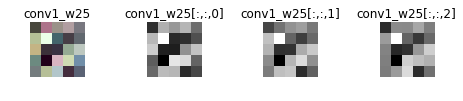

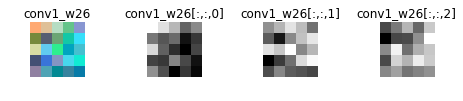

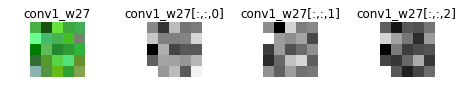

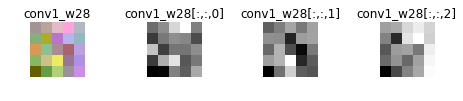

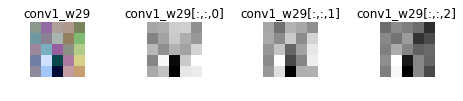

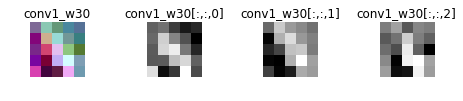

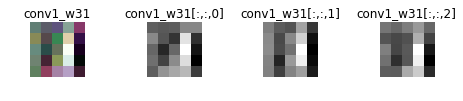

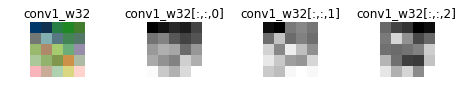

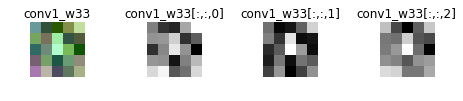

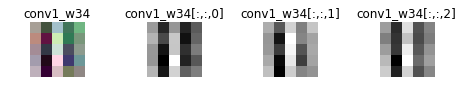

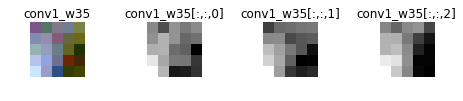

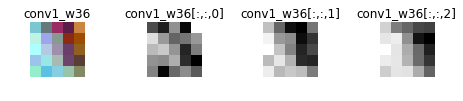

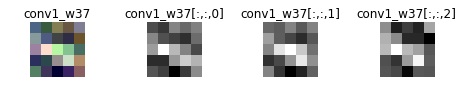

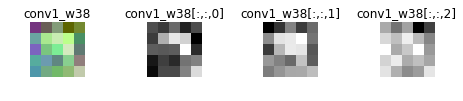

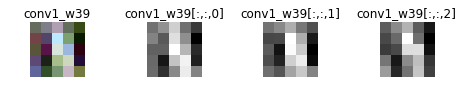

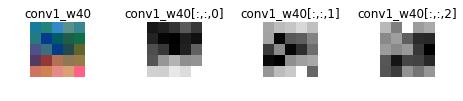

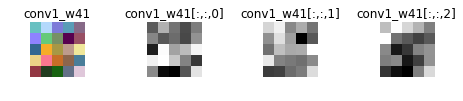

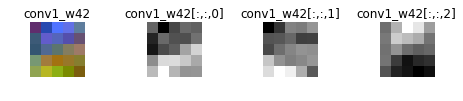

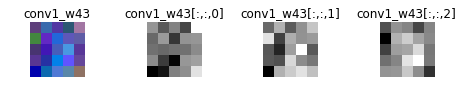

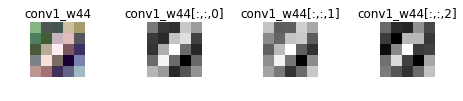

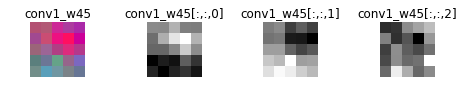

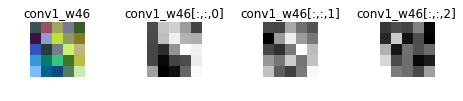

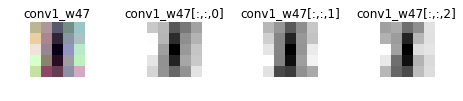

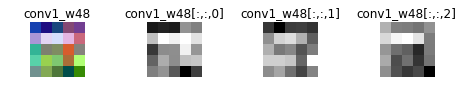

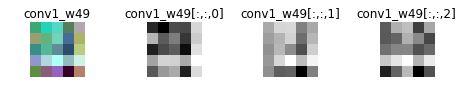

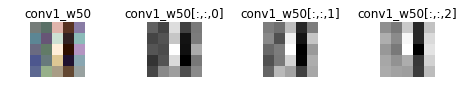

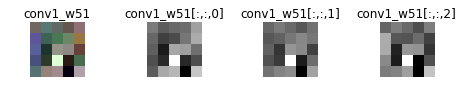

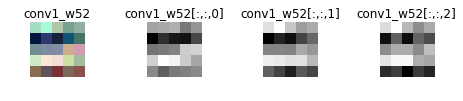

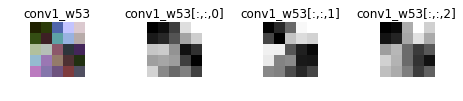

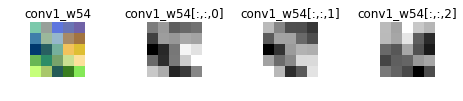

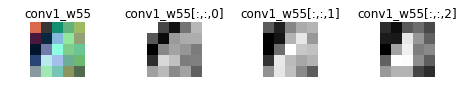

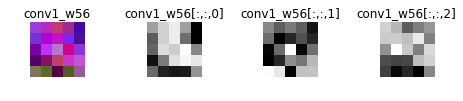

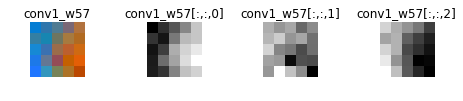

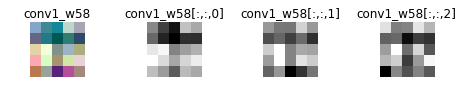

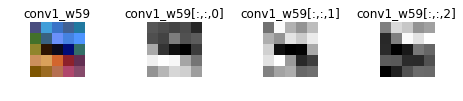

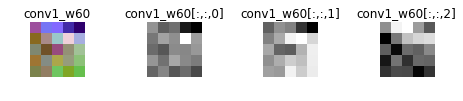

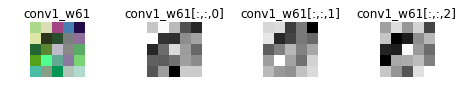

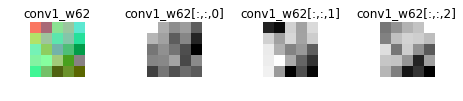

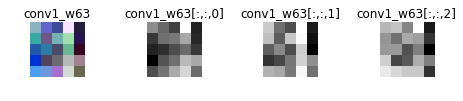

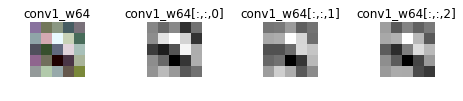

In [12]:
for i in range(conv1_w.shape[-1]):
    plt.figure(figsize=(8, 1))
    num_subplots = 4

    plt.subplot(1, num_subplots, 1)
    plt.imshow(normalize_img(conv1_w[:,:,:,i]))
    plt.axis('off')
    plt.title(f'conv1_w{i+1}')
    
    plt.subplot(1, num_subplots, 2)
    plt.imshow(normalize_img(conv1_w[:,:,0,i]), cmap='gray')
    plt.axis('off')
    plt.title(f'conv1_w{i+1}[:,:,0]')
    
    plt.subplot(1, num_subplots, 3)
    plt.imshow(normalize_img(conv1_w[:,:,1,i]), cmap='gray')
    plt.axis('off')
    plt.title(f'conv1_w{i+1}[:,:,1]')

    plt.subplot(1, num_subplots, 4)
    plt.imshow(normalize_img(conv1_w[:,:,2,i]), cmap='gray')
    plt.axis('off')
    plt.title(f'conv1_w{i+1}[:,:,2]')
    
    plt.show()

In [13]:
#!tensorboard --logdir='./logs'